# Simulation of image formation + image restoration
In this notebook we artifically assemble a microscope image from simlulated nuclei, noise and background. Afterwards, we use classical image processing techniques to remove noise and background.

In [1]:
import pyclesperanto_prototype as cle
import numpy as np
import pyopencl as cl

In [2]:
cl.get_platforms()

[<pyopencl.Platform 'NVIDIA CUDA' at 0x33b6150>]

In [3]:
image_size = (100, 100)

# noise configuration
noise_level = 2

# background configuration
camera_offset = 100
background_sigma = 25
background_intensity = 5

# nuclei configuration
nuclei_radius = 5
nuclei_blur_sigma = 1
nuclei_number = 10
nuclei_intensity = 5

In [4]:
# by pinning the random seed, we can make the code repeatable
np.random.seed(42)

In [5]:
cle.available_device_names()

['NVIDIA GeForce RTX 2080 Ti']

## Noise
Here we assume that the noise in the image is [Poisson distributed](https://en.wikipedia.org/wiki/Poisson_distribution), a common assumtion in microscopy.

Matplotlib is building the font cache; this may take a moment.


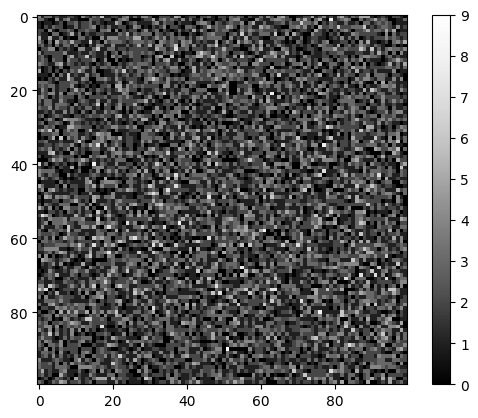

In [6]:
noise_image = np.random.poisson(noise_level, image_size)

cle.imshow(noise_image, colorbar=True)

## Background
Background intensity in fluorescence microscopy images typically comes from out-of-focus light. We can simulate this by placing light sources as single pixels and blurring them with a Gaussian filter. Furthermore, many microscope cameras have a so called camera offset. No pixel will ever have intensity below this value.

4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.


cl.OCLArray([[102.02708 , 102.05994 , 102.09012 , ..., 100.354485, 100.342865,
        100.3312  ],
       [102.09299 , 102.12704 , 102.158325, ..., 100.38394 , 100.37136 ,
        100.358734],
       [102.1577  , 102.192924, 102.22533 , ..., 100.41521 , 100.4016  ,
        100.387955],
       ...,
       [100.162254, 100.17418 , 100.18678 , ..., 100.57553 , 100.55186 ,
        100.52856 ],
       [100.15136 , 100.16256 , 100.17441 , ..., 100.53596 , 100.51383 ,
        100.492065],
       [100.14104 , 100.15154 , 100.16266 , ..., 100.49834 , 100.477684,
        100.457375]], dtype=float32)
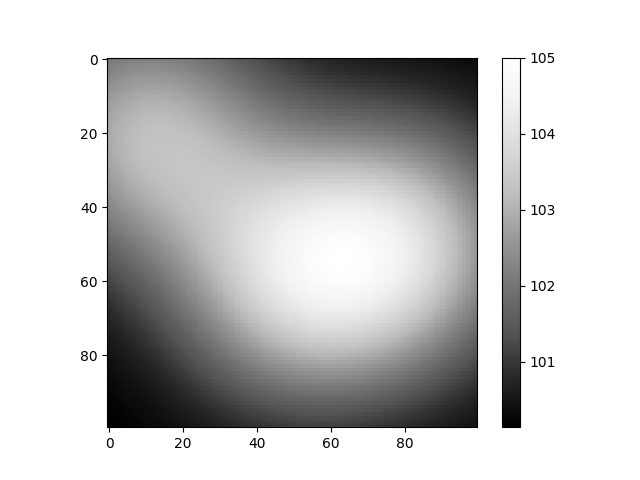
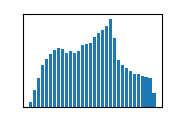

In [7]:
# create empty image
background = np.zeros(image_size)

# place light sources
background[20, 10] += 1
background[50, 80] += 1
background[60, 50] += 1

# blur them massively
background = cle.gaussian_blur(background, sigma_x=background_sigma, sigma_y=background_sigma)

# normalize the image so that the maximum intensity has a defined value
background = background / background.max() * background_intensity

# add camera offsert
background = background + camera_offset

background

## Nuclei
Next we place nuclei in an image at random positions. We blur them a bit to simulate the [point-spread-function](https://en.wikipedia.org/wiki/Point_spread_function) of the microscope.

cl.OCLArray([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 8.9553176e-08, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.9655941e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.2668341e-02,
        2.5692964e-03, 1.4035606e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.4986780e-03,
        1.4035606e-04, 6.0207412e-06],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.9183476e-05,
        3.0551471e-06, 8.9553176e-08]], dtype=float32)
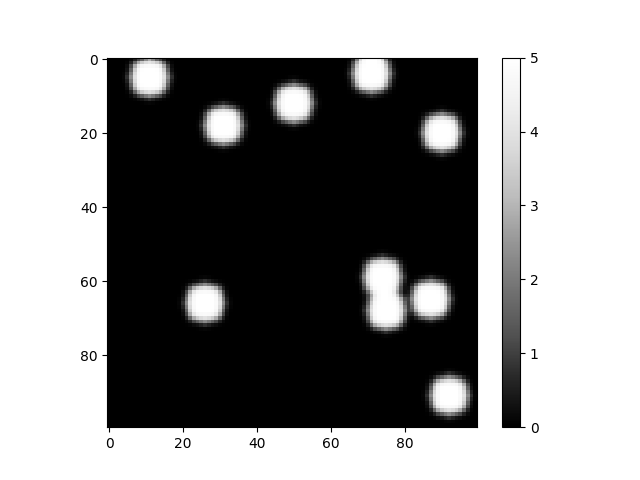
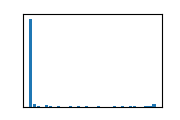

In [9]:
# retrieve a defined number of random positions
nuclei_positions = np.random.random((nuclei_number, 2)) * image_size

# write 1 at these locations
nuclei_image = cle.pointlist_to_labelled_spots(nuclei_positions.T, np.zeros(image_size))
nuclei_image = (nuclei_image > 0) * nuclei_intensity

# enlarge the nuclei by a define radius
nuclei_image = cle.maximum_sphere(nuclei_image, radius_x=nuclei_radius, radius_y=nuclei_radius)

# blur the image to make it look more realistic
nuclei_image = cle.gaussian_blur(nuclei_image, sigma_x=nuclei_blur_sigma, sigma_y=nuclei_blur_sigma)

nuclei_image

## Image formation
A microscopy image is the sum of the scence and the effect described above.

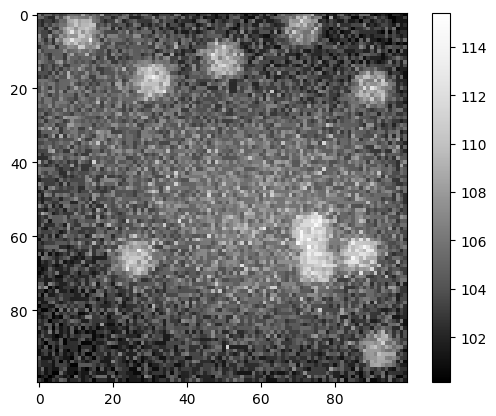

In [10]:
sum_image = np.asarray(noise_image + background + nuclei_image)

cle.imshow(sum_image, colorbar=True)

## Image segmentation
If we now applied a segmentation algorithm to this image as it is, it might lead to a wrong result.

4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.


cl.OCLArray([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
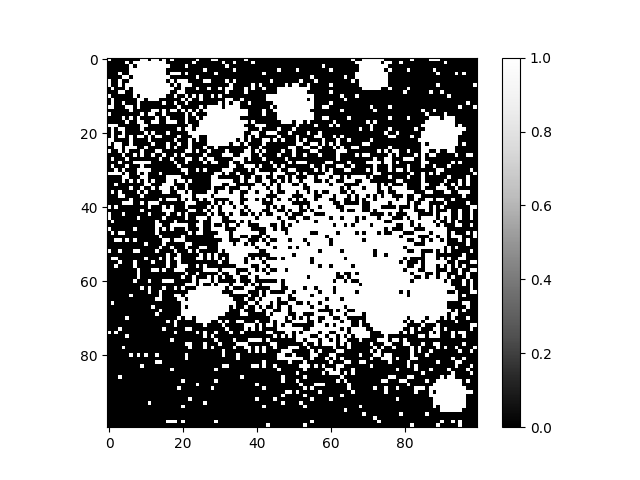
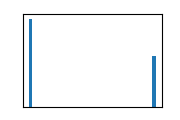

In [11]:
binary = cle.threshold_otsu(sum_image.astype(np.float32))

binary

## Background removal
To fix this problem, we need to remove the background intensity first.

4 warnings generated.
4 warnings generated.
4 warnings generated.


cl.OCLArray([[3.8401337 , 0.87299347, 2.9031754 , ..., 1.9769974 , 0.9653778 ,
        0.        ],
       [2.906044  , 2.940094  , 0.97138214, ..., 0.98750305, 0.9749222 ,
        2.9622955 ],
       [0.9647751 , 0.        , 0.926857  , ..., 0.98648834, 0.97288513,
        0.95923615],
       ...,
       [1.9481506 , 2.9600754 , 0.97267914, ..., 1.7506561 , 1.7068863 ,
        0.86231995],
       [0.        , 0.9756546 , 1.987503  , ..., 0.        , 0.        ,
        1.9781036 ],
       [2.9896774 , 1.988884  , 0.        , ..., 1.9609222 , 2.9637146 ,
        0.94340515]], dtype=float32)
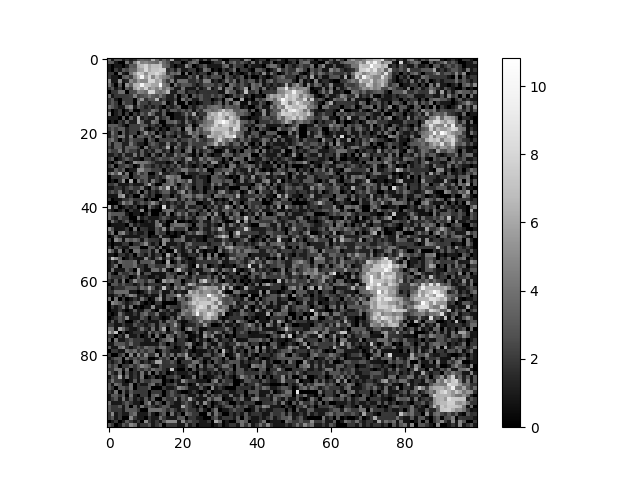
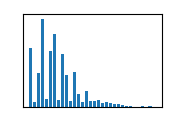

In [12]:
background_removed = cle.top_hat_box(sum_image, radius_x=10, radius_y=10)

background_removed

## Noise removal
We can also remove the noise from the image.

4 warnings generated.


cl.OCLArray([[104.74284 , 104.34828 , 104.09734 , ..., 101.47704 , 101.363914,
        101.35629 ],
       [104.30065 , 104.04471 , 103.93578 , ..., 101.66889 , 101.658714,
        101.65071 ],
       [104.0415  , 103.82112 , 103.75405 , ..., 101.83249 , 101.82167 ,
        101.675224],
       ...,
       [102.205376, 101.97187 , 101.775345, ..., 102.6444  , 102.41115 ,
        102.02973 ],
       [101.98917 , 101.82425 , 101.76516 , ..., 102.61183 , 102.322975,
        102.144394],
       [102.05105 , 101.98929 , 101.72292 , ..., 102.67943 , 102.23549 ,
        101.94183 ]], dtype=float32)
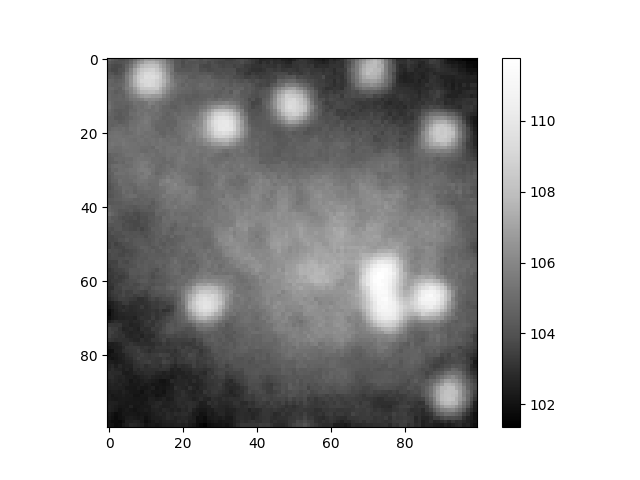
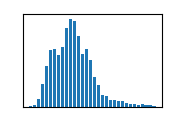

In [13]:
noise_removed1 = cle.mean_sphere(sum_image, radius_x=3, radius_y=3)

noise_removed1

And this can also be done on the background-subtracted image.

cl.OCLArray([[2.548792 , 2.1506062, 1.89332  , ..., 1.0842963, 0.9818381,
        0.9806079],
       [2.088405 , 1.8261153, 1.710844 , ..., 1.2460696, 1.249447 ,
        1.2490945],
       [1.7926522, 1.5659193, 1.492509 , ..., 1.3803769, 1.3803658,
        1.2459035],
       ...,
       [1.9805651, 1.7442198, 1.5428585, ..., 1.8543328, 1.6667336,
        1.3495907],
       [1.7917184, 1.6217978, 1.5557053, ..., 1.9150059, 1.6597024,
        1.5301003],
       [1.8778667, 1.8098779, 1.5343451, ..., 2.0488632, 1.6332661,
        1.3764796]], dtype=float32)
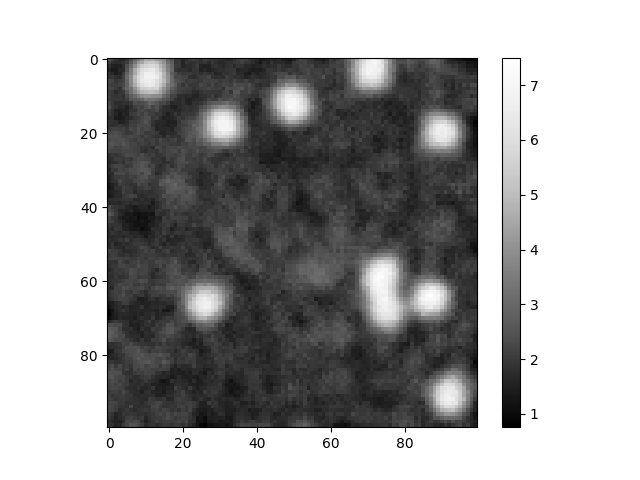
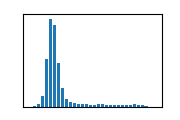

In [14]:
noise_removed = cle.mean_sphere(background_removed, radius_x=3, radius_y=3)

noise_removed

## Image segmentation II
After correcting the image, we can try segmentation again.

4 warnings generated.


cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
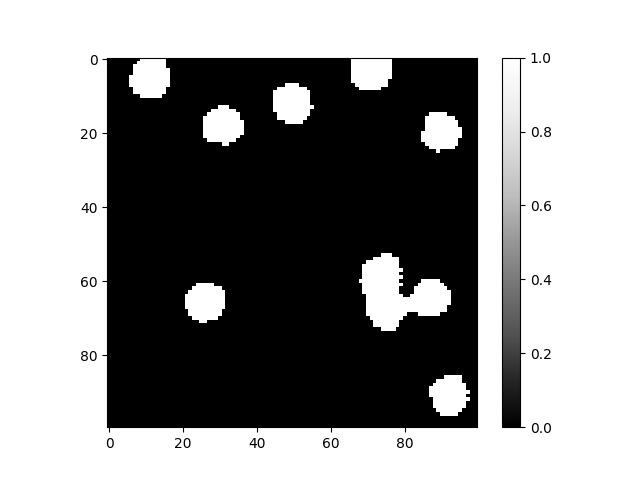
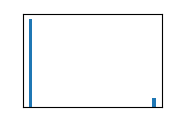

In [15]:
binary2 = cle.threshold_otsu(noise_removed.astype(np.float32))

binary2

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


StackViewNDArray([[False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
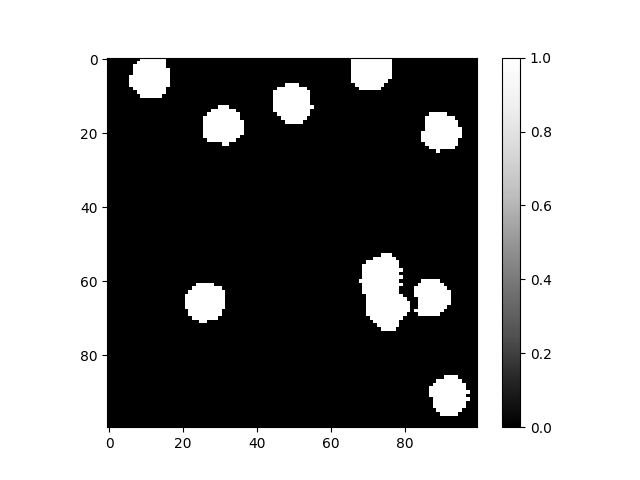
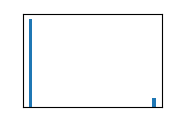

In [16]:
# sneak preview: watershed
import napari_segment_blobs_and_things_with_membranes as nsbatwm
binary3 = nsbatwm.split_touching_objects(binary2)

binary3